In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG, Audio
from keras.layers import Dropout
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-11-19 05:39:26.192118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 05:39:27.823060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 05:39:27.839023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 05:39:27.839128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [2]:
datasetPath = "../../datasets"

In [6]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

# Split Into Training and Testing
directory = "{datasetPath}/spectrogramsAlt3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join('{datasetPath}/spectrogramsAlt3sec/test/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:200]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,"{datasetPath}/spectrogramsAlt3sec/test/" + f"{g}")

# Split Into Training and Validation
directory = f"{datasetPath}/spectrogramsAlt3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrogramsAlt3sec/valid/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:50]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,f"{datasetPath}/spectrogramsAlt3sec/valid/" + f"{g}")

In [7]:
train_dir = "{datasetPath}/spectrogramsAlt3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

test_dir = f"{datasetPath}/spectrogramsAlt3sec/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [8]:
validation_dir = f"{datasetPath}/spectrogramsAlt3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

def GenreModel(input_shape = (288,432,4),classes=10):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [9]:
# checkpoint_path = "saved_cnn2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

model = GenreModel(input_shape=(288,432,4), classes=10)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

2022-11-19 05:39:28.165330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 05:39:28.166231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 05:39:28.166400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 05:39:28.166522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [10]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

In [11]:
if os.path.exists("../saved/saved_cnn2_3.h5"):
    model_history = model.load_model("../saved/saved_cnn2_3.h5")
else:
    model_history = model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)
    model.save("../saved/saved_cnn2_3.h5")

/tmp/ipykernel_52801/1228796320.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)


Epoch 1/70


2022-11-19 05:39:31.521777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2022-11-19 05:39:32.837330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - 75s 1s/step - loss: 2.3804 - accuracy: 0.2789 - get_f1: 0.2138 - val_loss: 2.4329 - val_accuracy: 0.1000 - val_get_f1: 0.0000e+00
Epoch 2/70
71/71 [==============================] - 68s 958ms/step - loss: 1.3509 - accuracy: 0.5199 - get_f1: 0.4881 - val_loss: 4.1893 - val_accuracy: 0.1000 - val_get_f1: 0.0992
Epoch 3/70
71/71 [==============================] - 68s 956ms/step - loss: 1.0567 - accuracy: 0.6287 - get_f1: 0.6148 - val_loss: 5.5958 - val_accuracy: 0.1840 - val_get_f1: 0.1779
Epoch 4/70
71/71 [==============================] - 68s 962ms/step - loss: 0.9501 - accuracy: 0.6676 - get_f1: 0.6647 - val_loss: 7.8320 - val_accuracy: 0.1000 - val_get_f1: 0.0997
Epoch 5/70
71/71 [==============================] - 68s 964ms/step - loss: 0.8163 - accuracy: 0.7149 - get_f1: 0.7109 - val_loss: 6.3377 - val_accuracy: 0.1930 - val_get_f1: 0.1964
Epoch 6/70
71/71 [==============================] - 68s 953ms/step - loss: 0.6943 - accuracy: 0.7596 - ge

Text(0, 0.5, 'Accuracy [%]')

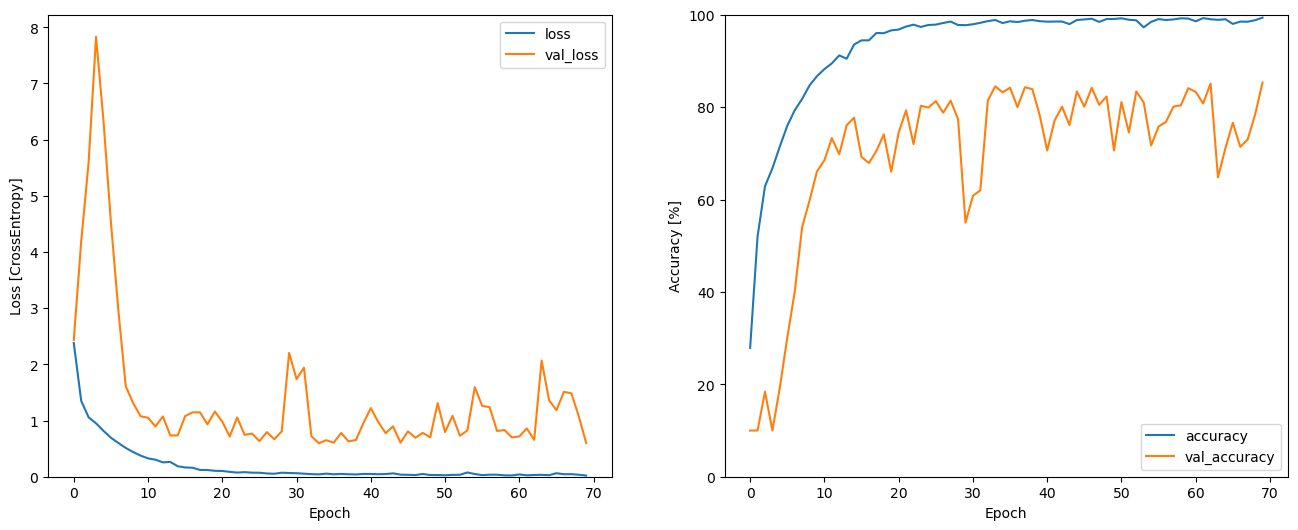

In [12]:
metrics = model_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(model_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')